# Biased Random Walk: Escape Probability Analysis

## Problem Statement

We want to simulate a biased random walk with the following characteristics:
- **Starting position**: 0 points
- **Goal**: Reach 100 points
- **Win rate function**: 
  - 50% chance of winning at 0 points
  - 15% chance of winning at 100 points
  - Linear interpolation between positions
- **Question**: What's the probability of **ever** reaching 100 points?

This is known as an "escape probability" problem in probability theory.

---

## Mathematical Background

This is a **biased random walk** with **position-dependent transition probabilities**. The key insight is that as we get closer to our goal (100), our win rate decreases, creating a "headwind" effect.

The win rate function is:
```
winrate(x) = 0.5 - 0.0035x
```

This creates:
- Higher win rates when we're negative (easier to climb back up)
- Lower win rates when we're positive (harder to reach the goal)

---

## How to Use This Notebook

1. **Run Cell 1**: Import libraries  
2. **Run Cell 2**: Define and test the win rate function  
3. **Run Cell 3**: Visualize the win rate function  
4. **Run Cell 4**: Test a single simulation run  
5. **Run Cell 5**: Define the main simulation function  
6. **Run Cell 6**: **THE BIG RUN** - Calculate the escape probability  
7. **Run Cell 7**: Analyze how the estimate converges  
8. **Run Cell 8**: Visualize sample random walk paths  
9. **Run Cell 9**: Read theoretical insights  
10. **Run Cell 10**: Optional extended analysis

---

## Expected Results

Based on the mathematical properties of this biased random walk, we expect:

- **Escape probability**: Very low (likely 0.1% to 5%)
- **Successful runs**: Take many steps (often 10,000+)
- **Deep dips**: Successful runs often go very negative first
- **High variance**: Some runs succeed quickly, others take forever

The exact value depends on the precise balance between the "headwind" effect (decreasing win rates) and the "recovery" effect (higher win rates when negative).

---

## Next Steps

After running the simulation, you might want to:

1. **Increase precision**: Run with 1,000,000+ runs  
2. **Try different functions**: Exponential decay instead of linear  
3. **Add boundaries**: What if there's a "bankruptcy" level?  
4. **Optimize parameters**: Find the break-even win rate function  
5. **Theoretical solution**: Derive the exact probability analytically

---

*Notebook created for biased random walk escape probability analysis.*


In [1]:
# Cell 1: Import libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Define the win rate function
def get_winrate(points):
    """
    Calculate winrate based on current points.

    Args:
        points (int): Current position in the walk

    Returns:
        float: Win probability between 0.01 and 0.99

    Mathematical model:
    - At 0 points: 50% winrate
    - At 100 points: 15% winrate  
    - Linear interpolation: winrate = 0.5 - (points * 0.0035)
    """
    winrate = 0.5 - (points * 0.0035)

    # Clamp between 1% and 99% to avoid impossible probabilities
    return max(0.01, min(0.99, winrate))

# Test the function
print("Win rate examples:")
print(f"At -100 points: {get_winrate(-100):.1%}")
print(f"At 0 points: {get_winrate(0):.1%}")
print(f"At 50 points: {get_winrate(50):.1%}")
print(f"At 100 points: {get_winrate(100):.1%}")

Win rate examples:
At -100 points: 85.0%
At 0 points: 50.0%
At 50 points: 32.5%
At 100 points: 15.0%


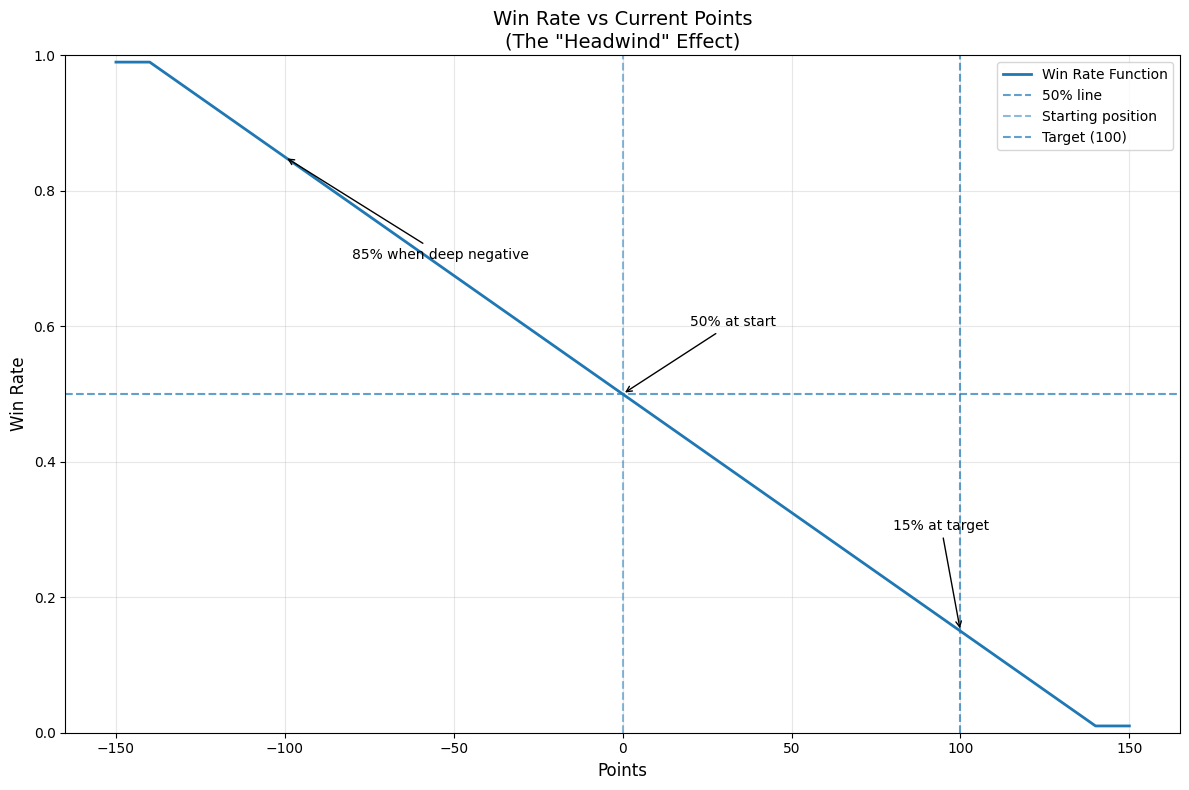

In [3]:
# Cell 3: Visualize the win rate function
def plot_winrate_function():
    """Plot the win rate function to understand the bias."""
    points = np.linspace(-150, 150, 301)
    winrates = [get_winrate(p) for p in points]

    plt.figure(figsize=(12, 8))
    plt.plot(points, winrates, linewidth=2, label='Win Rate Function')

    # Add reference lines
    plt.axhline(y=0.5, linestyle='--', alpha=0.7, label='50% line')
    plt.axvline(x=0, linestyle='--', alpha=0.5, label='Starting position')
    plt.axvline(x=100, linestyle='--', alpha=0.7, label='Target (100)')

    # Formatting
    plt.xlabel('Points', fontsize=12)
    plt.ylabel('Win Rate', fontsize=12)
    plt.title('Win Rate vs Current Points\n(The "Headwind" Effect)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)

    # Add annotations
    plt.annotate('50% at start', (0, 0.5), xytext=(20, 0.6),
                arrowprops=dict(arrowstyle='->'),
                fontsize=10)
    plt.annotate('15% at target', (100, 0.15), xytext=(80, 0.3),
                arrowprops=dict(arrowstyle='->'),
                fontsize=10)
    plt.annotate('85% when deep negative', (-100, 0.85), xytext=(-80, 0.7),
                arrowprops=dict(arrowstyle='->'),
                fontsize=10)

    plt.tight_layout()
    plt.show()

# Generate the plot
plot_winrate_function()

In [4]:
# Cell 4: Single run simulation
def simulate_single_run(target=100, max_steps=50000, track_path=False):
    """
    Simulate a single random walk run.

    Args:
        target (int): Points needed to win
        max_steps (int): Maximum steps before timeout
        track_path (bool): Whether to return the full path

    Returns:
        tuple: (result, steps_taken, min_points, [path])
    """
    points = 0
    steps = 0
    min_points = 0
    path = [0] if track_path else None

    while steps < max_steps:
        # Check win condition
        if points >= target:
            result = 'success'
            break

        # Make a move based on current win rate
        winrate = get_winrate(points)
        if random.random() < winrate:
            points += 1  # Win
        else:
            points -= 1  # Loss
            min_points = min(min_points, points)

        if track_path:
            path.append(points)

        steps += 1
    else:
        result = 'timeout'

    if track_path:
        return result, steps, min_points, path
    return result, steps, min_points

# Test a single run
result, steps, min_points = simulate_single_run()
print(f"Test run result: {result}")
print(f"Steps taken: {steps:,}")
print(f"Lowest point reached: {min_points}")

Test run result: timeout
Steps taken: 50,000
Lowest point reached: -27


In [5]:
# Cell 5: Main simulation function
def run_simulation(num_runs=100000, target=100, verbose=True):
    """
    Run multiple simulations and calculate escape probability.

    Args:
        num_runs (int): Number of simulation runs
        target (int): Target points to reach
        verbose (bool): Print progress and results

    Returns:
        tuple: (escape_probability, detailed_results)
    """
    from collections import defaultdict
    results = defaultdict(int)
    successful_steps = []
    successful_min_points = []

    if verbose:
        print(f"🎯 ESCAPE PROBABILITY SIMULATION")
        print(f"{'='*50}")
        print(f"Target: {target} points")
        print(f"Runs: {num_runs:,}")
        print(f"Win rate: 50% → 15% (0 → {target} points)")
        print(f"No negative boundary (infinite attempts)")
        print(f"{'='*50}")

        start_time = time.time()

    # Run simulations
    for i in range(num_runs):
        if verbose and (i + 1) % 10000 == 0:
            elapsed = time.time() - start_time
            rate = (i + 1) / elapsed if elapsed > 0 else float('inf')
            print(f"Progress: {i + 1:,} runs ({rate:.0f} runs/sec)")

        result, steps, min_points = simulate_single_run(target)
        results[result] += 1

        if result == 'success':
            successful_steps.append(steps)
            successful_min_points.append(min_points)

    # Calculate statistics
    total_runs = sum(results.values())
    escape_prob = results['success'] / total_runs if total_runs else 0.0
    timeout_rate = results['timeout'] / total_runs if total_runs else 0.0

    if verbose:
        elapsed = time.time() - start_time
        print(f"\n🏁 SIMULATION COMPLETE ({elapsed:.1f} seconds)")
        print(f"{'='*50}")
        print(f"Successful runs: {results['success']:,}")
        print(f"Timed out runs: {results['timeout']:,}")
        print(f"")
        print(f"🎲 ESCAPE PROBABILITY: {escape_prob:.4%}")
        print(f"{'='*50}")

        if timeout_rate > 0.01:
            print(f"⚠️  WARNING: {timeout_rate:.2%} of runs timed out")
            print(f"Consider increasing max_steps for better accuracy")

        # Analysis of successful runs
        if successful_steps:
            print(f"\n📊 SUCCESSFUL RUNS ANALYSIS:")
            print(f"Average steps to success: {np.mean(successful_steps):,.0f}")
            print(f"Median steps to success: {np.median(successful_steps):,.0f}")
            print(f"Fastest success: {min(successful_steps):,} steps")
            print(f"Slowest success: {max(successful_steps):,} steps")
            print(f"")
            print(f"Average lowest dip: {np.mean(successful_min_points):,.1f} points")
            print(f"Worst dip in success: {min(successful_min_points):,} points")

    detailed_results = {
        'escape_probability': escape_prob,
        'successful_steps': successful_steps,
        'successful_min_points': successful_min_points,
        'timeout_rate': timeout_rate,
        'raw_results': dict(results)
    }

    return escape_prob, detailed_results

# This cell just defines the function - we'll run it in the next cell
print("Simulation function defined. Ready to run!")

Simulation function defined. Ready to run!


In [6]:
# Cell 6: Run the main simulation
print("🚀 Starting main simulation...\n")

# Run the simulation
escape_probability, results = run_simulation(num_runs=100000, target=100)

print(f"\n🎯 FINAL ANSWER: The probability of ever reaching 100 points is {escape_probability:.4%}")

🚀 Starting main simulation...

🎯 ESCAPE PROBABILITY SIMULATION
Target: 100 points
Runs: 100,000
Win rate: 50% → 15% (0 → 100 points)
No negative boundary (infinite attempts)
Progress: 10,000 runs (36 runs/sec)
Progress: 20,000 runs (37 runs/sec)
Progress: 30,000 runs (37 runs/sec)
Progress: 40,000 runs (37 runs/sec)
Progress: 50,000 runs (37 runs/sec)
Progress: 60,000 runs (37 runs/sec)
Progress: 70,000 runs (38 runs/sec)
Progress: 80,000 runs (38 runs/sec)
Progress: 90,000 runs (38 runs/sec)
Progress: 100,000 runs (38 runs/sec)

🏁 SIMULATION COMPLETE (2610.5 seconds)
Successful runs: 0
Timed out runs: 100,000

🎲 ESCAPE PROBABILITY: 0.0000%
⚠️  WARNING: 100.00% of runs timed out
Consider increasing max_steps for better accuracy

🎯 FINAL ANSWER: The probability of ever reaching 100 points is 0.0000%
